# Install detectron2

In [5]:
#dependencies
!pip install --upgrade pip
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
torchvision.__version__
!gcc --version

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

     |████████████████████████████████| 1.4MB 7.1MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 42 kB/s s eta 0:00:01  |▍                               | 8.6 MB 562 kB/s eta 0:21:12     |▌                               | 10.4 MB 562 kB/s eta 0:21:09��███████▎              | 391.7 MB 2.1 MB/s eta 0:02:38     |██████████████████▋             | 420.9 MB 1.6 MB/s eta 0:03:14MB 2.0 MB/s eta 0:01:50��███████████████████▉   | 651.0 MB 1.7 MB/s eta 0:00:43    |██████████████████████████████  | 680.7 MB 7.8 MB/s eta 0:00:06��███████████▉| 719.0 MB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 575 kB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Attempting uni

  Created wheel for fvcore: filename=fvcore-0.1.dev200308-py3-none-any.whl size=37813 sha256=9887c00c3782ed8c9dc3905701913f81a74aa596d12c73750dacc7fba5c69579
  Stored in directory: /home/Deep_Learner/.cache/pip/wheels/f0/c8/fa/13d4d380de3f4b1b947850bdddab77dc1874d06c107b9a2e76
Successfully built fvcore


# Imports

In [87]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
from tqdm import tqdm_notebook as tqdm
import PIL
from PIL import Image
import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util
import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
from pycocotools import mask

 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution.csv'

seed = 19
np.random.seed(seed)

# util functions

In [70]:
def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np(arr:numpy.ndarray):
    plt.imshow(arr)
    plt.show()

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray]):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show()    

def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    masks = [open_mask_as_np(p) for p in path.ls()]
    return merge_masks(masks, shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle]))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))

def rle_encode_pycocotools(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format. 
        e.g. {'size': [256, 256], 'counts': b'lf<2m75H5M3O1N1O2O0000000001O000O2M4MZQ_1'}        
    '''
    return pycocotools.mask.encode(np.asarray(mask_np, order="F"))

# dataset

## load csv

In [3]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [4]:
s1_trn_lbs_df

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
...,...,...
29456,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...
29457,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,110318 4 110675 13 111034 19 111391 23 111750 ...
29458,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...
29459,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...


In [5]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

## merge existing single masks of one image

In [6]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [7]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

PosixPath('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks')

In [8]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [9]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

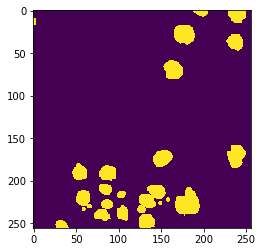

In [10]:
show_np(merged_mask)

## decode run length encoding to mask

In [11]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [12]:
merged_mask = merge_masks(masks)

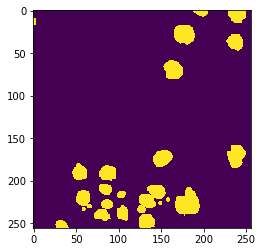

In [13]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth

In [14]:
img_id

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

In [15]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

PosixPath('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552')

In [16]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

PosixPath('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks')

In [67]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [71]:
merged_mask = merge_masks_from_path(masks_p)

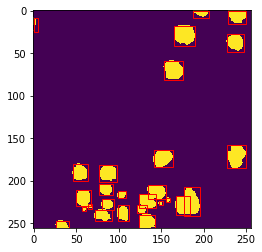

In [72]:
show_np_with_bboxes(merged_mask,bboxes)

## Custom dataset for detectron2

### Example custom dataset balloons (https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=4Qg7zSVOulkb)

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

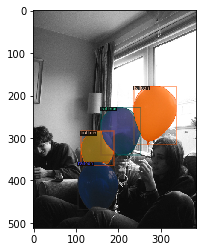

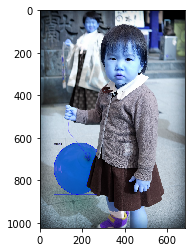

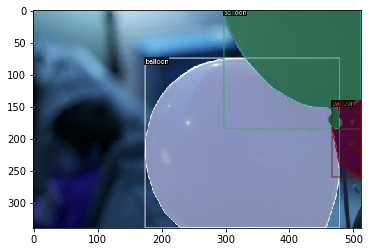

In [7]:
dataset_dicts = get_balloon_dicts("./balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

### Custom dataset for nuclei detection

In [154]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

In [155]:
df_rle_labels = pd.concat([pd.read_csv(STAGE1_TRAIN_LABELS), 
                             pd.read_csv(STAGE1_TEST_LABELS)], 
                            ignore_index=True, sort=False)

def get_nuclei_dicts(dataset_path):
    """
    Arguments:
        dataset_path: STAGE1_TRAIN or STAGE1_TEST
    """

    img_paths = [path/'images'/f'{path.name}.png' for path in dataset_path.ls()]
    
    dataset_dicts = []
    for path in tqdm(train_paths):
        record = {}
        
        img_pil = PIL.Image.open(path)         
        width = img_pil.width
        height = img_pil.height
        
        record["file_name"] = path
        record["image_id"] = path.stem
        record["height"] = height
        record["width"] = width
      
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels)
        objs = []
        for mask in masks:
            obj = {
                "bbox": list(mask_to_bbox(mask)),
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [rle_encode_pycocotools(mask)],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in [STAGE1_TRAIN, STAGE1_TEST]:
    DatasetCatalog.register("nuclei_" + d.name, lambda d=d: get_balloon_dicts(d))
    MetadataCatalog.get(f"nuclei_{d.name}").set(thing_classes=["nucleus"])

nuclei_metadata = MetadataCatalog.get(f"nuclei_{STAGE1_TRAIN.name}")

In [ ]:
dataset_dicts = get_nuclei_dicts(STAGE1_TRAIN)

In [158]:
for d in random.sample(dataset_dicts, 3):
    #print(d["file_name"])
    #img = cv2.imread(d["file_name"])
    img = np.asarray(Image.open(p))
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

ValueError: cannot reshape array of size 1 into shape (2)

In [143]:
p = '/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b/images/8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b.png'

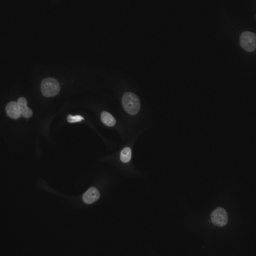

In [162]:
img_pil = Image.open(p);img_pil

In [166]:
img_pil_np = np.asarray(img_pil)

In [176]:
img_pil_np.shape

(256, 256, 4)

In [177]:
img_pil_np[:, :, ::-1].shape

(256, 256, 4)

In [168]:
img_cv2_np = cv2.imread(p)

In [174]:
img_cv2_np.shape

(256, 256, 3)

In [175]:
img_cv2_np[:, :, ::-1].shape

(256, 256, 3)